# Flow modelling proof of concept

In [1]:
import graph_tool as gt
import graph_tool.draw
import numpy as np
import datetime
import cairo

In [2]:
print("Date:", datetime.datetime.now().date().isoformat())

Date: 2018-08-23


## Test data

Let's create an test graph that models cucumber production, packaging and consumption.

In [3]:
G = gt.Graph(directed=True)
G.add_vertex(12)
vid = G.new_vertex_property("string")
G.vertex_properties["id"] = vid
G.vp.id[0] = 'Farm'
G.vp.id[1] = 'Packaging'
G.vp.id[2] = 'Oil rig'
G.vp.id[3] = 'Oil refinery'
G.vp.id[4] = 'Stock 1'
G.vp.id[5] = 'Production'
G.vp.id[6] = 'Consumption'
G.vp.id[7] = 'Waste'
G.vp.id[8] = 'Burn'
G.vp.id[9] = 'Recycling'
G.vp.id[10] = 'Stock 2'
G.vp.id[11] = 'Waste 2'
flow = G.new_edge_property("object")
G.edge_properties["flow"] = flow
G.add_edge(G.vertex(0), G.vertex(1))
G.add_edge(G.vertex(2), G.vertex(3))
G.add_edge(G.vertex(3), G.vertex(4))
G.add_edge(G.vertex(3), G.vertex(5))
G.add_edge(G.vertex(5), G.vertex(1))
G.add_edge(G.vertex(1), G.vertex(6))
G.add_edge(G.vertex(6), G.vertex(7))
G.add_edge(G.vertex(6), G.vertex(8))
G.add_edge(G.vertex(6), G.vertex(9))
G.add_edge(G.vertex(9), G.vertex(10))
G.add_edge(G.vertex(9), G.vertex(5))
G.add_edge(G.vertex(6), G.vertex(11))
G.ep.flow[(0,1)] = {'mass':95, 'composition':{'cucumber':0.3158, 'milk':0.6842}}
G.ep.flow[(2,3)] = {'mass':20, 'composition':{'crude oil':1.0}}
G.ep.flow[(3,4)] = {'mass':16, 'composition':{'petrol':1.0}}
G.ep.flow[(3,5)] = {'mass':4, 'composition':{'plastic':1.0}}
G.ep.flow[(5,1)] = {'mass':5, 'composition':{'plastic':1.0}}
G.ep.flow[(1,6)] = {'mass':100, 'composition':{'plastic':0.05, 'cucumber':0.3, 'milk':0.65}}
G.ep.flow[(6,7)] = {'mass':75, 'composition':{'human waste':1.0}}
G.ep.flow[(6,8)] = {'mass':3, 'composition':{'plastic':1.0}}
G.ep.flow[(6,9)] = {'mass':2, 'composition':{'plastic':1.0}}
G.ep.flow[(9,10)] = {'mass':1, 'composition':{'waste':1.0}}
G.ep.flow[(9,5)] = {'mass':1, 'composition':{'plastic':1.0}}
G.ep.flow[(6,11)] = {'mass':20, 'composition':{'other waste':1.0}}

In [4]:
G.save("cucumba.gt")

In [5]:
t = (i for i in G.ep.flow)
txt = G.new_edge_property("string", vals=t)

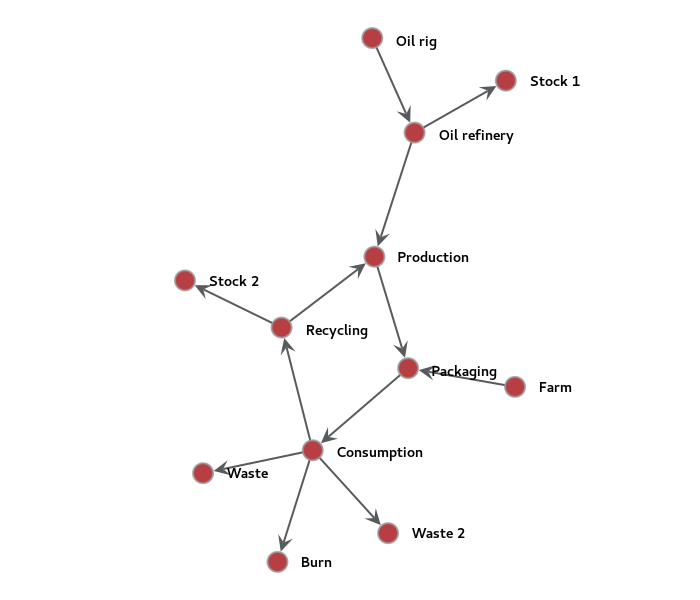

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e7e48, at 0x7fa32a600c18>

In [6]:
gt.draw.graph_draw(G, vertex_size=20, vertex_text=G.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   output_size=(700,600), inline=True)

## Flow splitting

In the GDSE, flows have two properties, *mass* [tons] and *material composition* [fraction]. In order to compute stuff in the graph, the flows (edges) need to be split per material, often resulting in paralell edges.

In [7]:
def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding mass.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_mass
        Edge property (mass), double
    vtx_mask
        Vertex property, bool
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    mass_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            mass_list.append(float(prop['mass']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_mass = g.new_edge_property("float", vals=mass_list)
    eprop_mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    r = (False for x in g.get_vertices())
    vtx_mask = g.new_vertex_property("bool", vals=r)
    return (g, eprop_material, eprop_mass, eprop_mass_text, vtx_mask)

In [8]:
g_split, eprop_material, eprop_mass, eprop_mass_text, vtx_mask = split_flows(G)

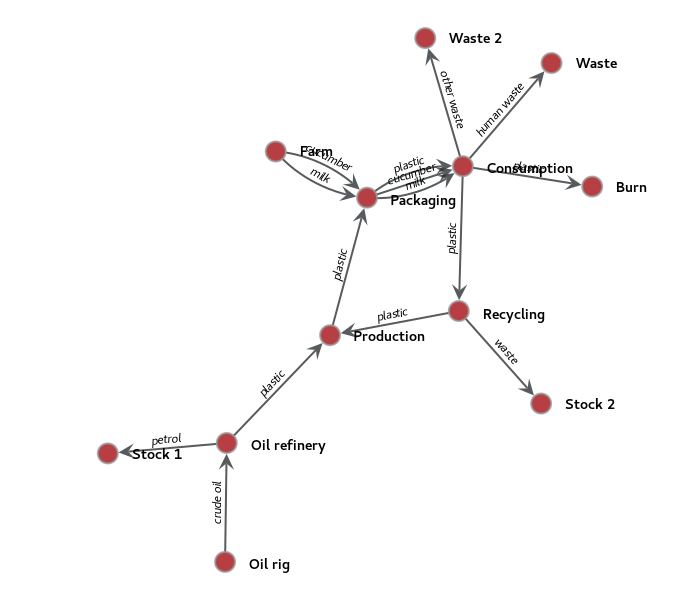

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa32a5e77b8>

In [9]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

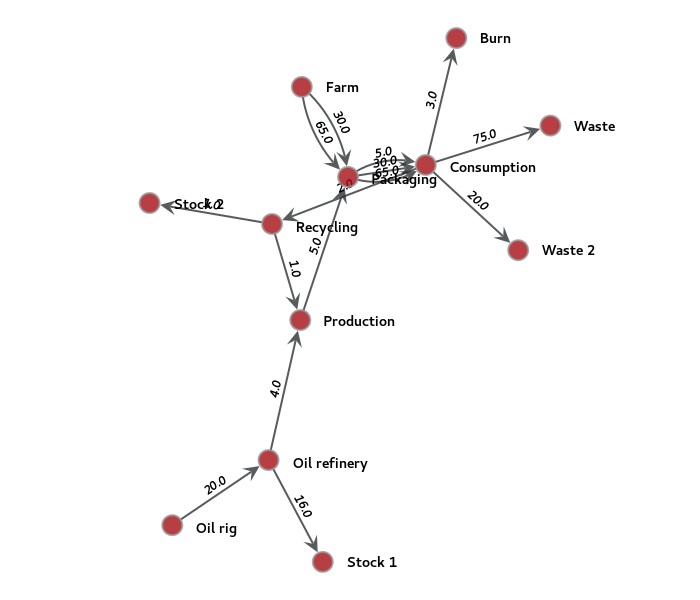

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa32a5cc940>

In [10]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

## Solution 1 – plastic reduction

*Reduce the amount of plastic between Packaging and Consumption by 20% in the part of the cucumber packaging* (blue edge)

In other words:

There are 30t of cucumbers (net), plus 5% over it in plastic, thus 1,5t of plastic, between Packaging and Consumption. The solution reduces the 1,5t by 20%, thus there will be only **1,2t** of plastic (blue arrow). As an effect, the plastic-related upstream and downstream flows need to change, but the *1,2t* will stay as set manually.

In [11]:
pe = g_split.edge(g_split.vertex(1), g_split.vertex(6), all_edges=True) # the 3 edges between Packaging and Cosumption
sol_e = [e for e in pe if eprop_material[e] == 'plastic'][0] # the specific edge (blue)

In [12]:
# Now we 'implement' the solution. No need to copy the graph, just the property map
eprop_mass_sol = eprop_mass.copy()
# The plastic flow contains the combined mass from cucumber and milk packaging, which is 5.0t. From the 5.0t, 1,5t was
# used for cucumbers as explained above. Now, the solution reduces the packaging of cucumbers by 0.3t
print("Current combined plastic mass after Packaging", eprop_mass_sol[sol_e])
solution = 0.3
eprop_mass_sol[sol_e] = eprop_mass_sol[sol_e] - solution
print("Plastic mass after implementing the solution", eprop_mass_sol[sol_e])

Current combined plastic mass after Packaging 5.0
Plastic mass after implementing the solution 4.7


#### Other solutions to test:

+ reduce packaging by 3.0t, 4.0t
+ remove packaging completely (reducy by 5.0t)

### Restricting the graph with the Solution

We need to restrict the graph to the flows that are involved in the *Solution*, otherwise flows might be altered that are not affected by the solution. For example, the solution affects the *Packaging* activity and reduces the amount of plastic packaging on cucumbers by 20%. Thus neither the amount of cucumbers nor the amount of milk should be changed.

Both the milk and cucumber *packaged product* consists of 5% plastic.

Thus the provided solution modfies the *green* edges and must not modify the *red* edges. The user is supposed to manually select the flows (green and blue edges) that are affected by the solution.

In [13]:
cols = []
sol_edges = [] # edges affected by the solution
edge_mask = g_split.new_edge_property("bool")
for i, e in enumerate(g_split.edges()):
    if eprop_material[e] in ['plastic', 'crude oil']:
        cols.append("green")
        sol_edges.append(e)
        edge_mask[e] = True
        vtx_mask[e.source()] = True
        vtx_mask[e.target()] = True
    else:
        cols.append("red")
        edge_mask[e] = False
ecolors = g_split.new_edge_property("string", vals=cols)
#sol_e = sol_edges[0] # the flow/edge that is directly affected by the solution (reduction of plastic packaging).
                     # I know that is the first in the array because i checked manually for the test
ecolors[sol_e] = "blue"

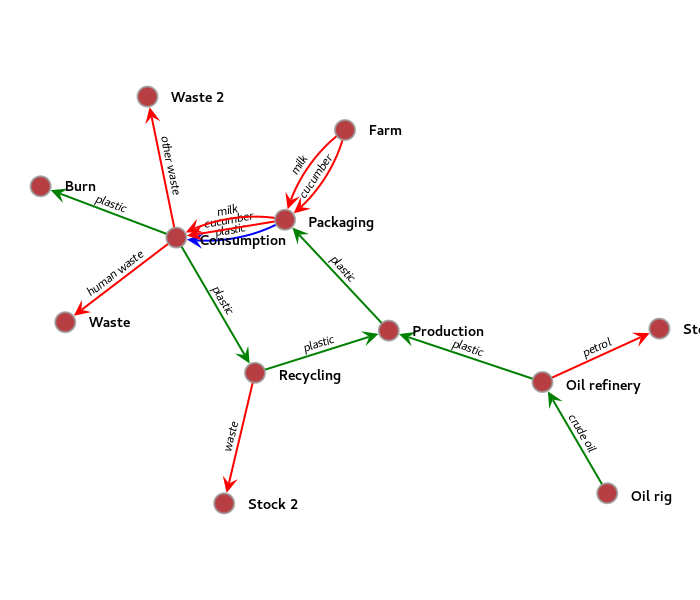

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa32a5e3eb8>

In [14]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

Mask the edges that are not included in the solution

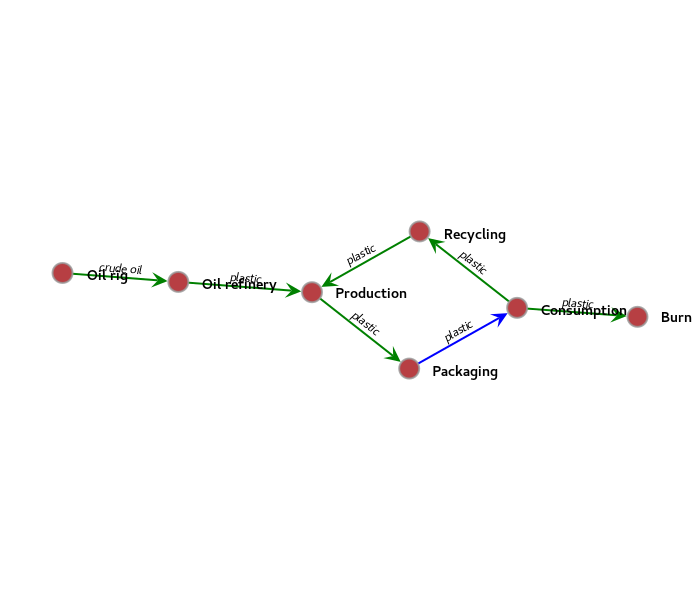

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa32a5cccc0>

In [15]:
g_split.set_edge_filter(edge_mask)
g_split.set_vertex_filter(vtx_mask)
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

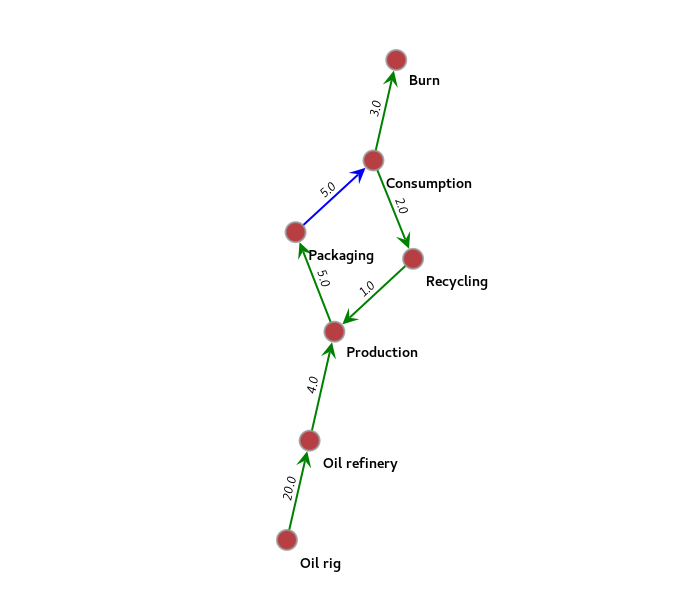

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa32a5cc908>

In [16]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_text,
                   output_size=(700,600), inline=True)

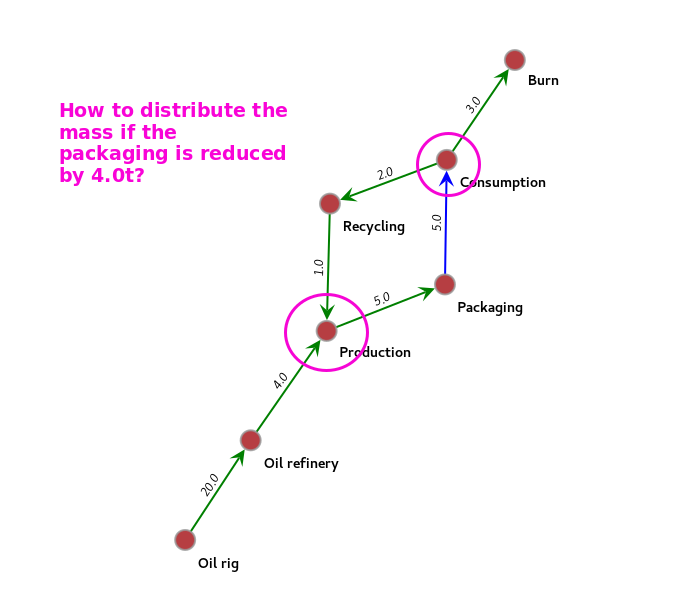

At some point when the graph was created, decisions were made on the distribution of mass in the in- and outflows at each node. We assume these decisions to be still valid. Thus when a node has multipe in- or outflows, a *contribution* factor is computed for each flow and each flow is modified according to its contribution. For example, at *Production* 4.0t (80%) comes from the *Oil refinery*, 1.0t (20%) from *Recycling*. If plastic is reduced by 4.0t in total, then the inflow from *Oil refinery* is reduced by $4.0t*0.8=3.2t$, the inflow from *Recycling* is reduced by $4.0t*0.2=0.8t$. Thus the new inflow from *Oil refinery* is 0.8t, from *Recycling* is 0.2t.

### The algorithm test

src <- get the source node of *sol_e*

all_sources <- get all the Source nodes in the graph (nodes without souce edge)

spaths <- compute all shortest paths from *src* to *all_sources*

*mass update*: the amount by which a solution modifies a flow. In this example is -0.3t

update the restricted flows along *spaths* with the *mass update*

....

Actually, probably there is no need at all for complicated graph traversal to update the flow. Once I have the correct flows isolated, they can be simply modified by the *update factor*, the result will be the same as with the 'walker' approach.

#### Alternative 1

Take the restricted graph

For each node:\
    Compute the *mass-ratio* for the in and out edges. Where $in\_mass\_ratio=\frac{mass}{total\_inflow}$ , or the same for outflows. Where the *in_mass_ratio* is assigned to the incoming edge, the *out_mass_ratio* is assigned to the outgoing edge of the node. If there is no edge then the ratio is 0.

Compute *mass update*, which is the amount by which a solution modifies a flow. In this example is -0.3t

For each edge:\
    

#### Alternative 2

Compute $balancing\_factor=\frac{solution}{solution\_flow}$ , where *solution* is the amount in *t* by which the *Solution* modifies the *solution_flow* (the *plastic* between *Packaging* and *Consumption*)

Multiply each edge in the restricted graph by the *balancing_factor*

In [17]:
bf = solution / eprop_mass[sol_e]
if bf < 1.0:
    balancing_factor = 1.0 - bf
else:
    balancing_factor = bf
print("balancing_factor:", balancing_factor)

balancing_factor: 0.94


In [18]:
eprop_mass_sol = g_split.new_edge_property("double", vals=eprop_mass.ma * balancing_factor) # balance the graph

**The new flows:**

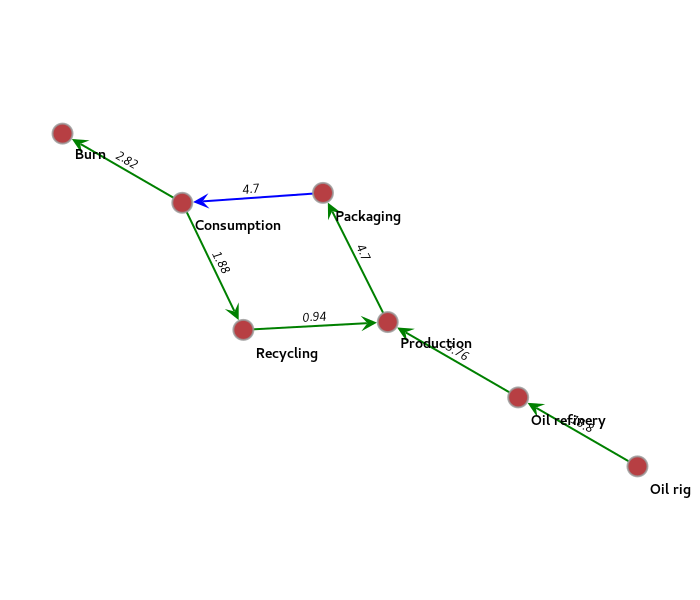

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa32a600240>

In [19]:
eprop_mass_text_sol = g_split.new_edge_property("string", vals=[round(i,2) for i in eprop_mass_sol])
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_text_sol,
                   output_size=(700,600), inline=True)

## Solution 2 – milk reduction

*Reduce milk production by 40%*

The current milk production is $0.6842*95=65t$ , after implementing the solution it will be reduced by 26t. Thus the __*balancing_factor* for milk is 0.6__ .

Milk is also packaged in plastic, which is *5.4%* (because 3.5/65) over the net mass of the milk. Reducing the milk also reduces the plastic, thus at the end we'll end up with $(65t * 0.6) * 0.054 = 2.106t$ of plastic packaging for the milk. Which is $2.106/3.5=0.6017$ 

In [20]:
g_split.clear_filters() # remove the edge and vertex masks

In [21]:
pe = g_split.edge(g_split.vertex(0), g_split.vertex(1), all_edges=True) # the 2 edges between Farm and Packaging
sol_e = [e for e in pe if eprop_material[e] == 'milk'][0] # the specific edge (blue)

print("Current milk mass after Farm", round(eprop_mass[sol_e],2))
solution = 26
sol_mass = eprop_mass[sol_e] - solution
print("Milk mass after implementing the solution", round(sol_mass,2))

Current milk mass after Farm 65.0
Milk mass after implementing the solution 39.0


The flows affected by the solution are manually selected by the user.

In [22]:
# reset masks
for e in g_split.edges():
    edge_mask[e] = False
    vtx_mask[e.source()] = False
    vtx_mask[e.target()] = False

cols = []
sol_edges = [] # edges affected by the solution
for i, e in enumerate(g_split.edges()):
    if eprop_material[e] in ['milk', 'human waste', 'other waste']:
        cols.append("green")
        sol_edges.append(e)
        edge_mask[e] = True
        vtx_mask[e.source()] = True
        vtx_mask[e.target()] = True
    else:
        cols.append("red")
        edge_mask[e] = False
ecolors = g_split.new_edge_property("string", vals=cols)
ecolors[sol_e] = "blue"

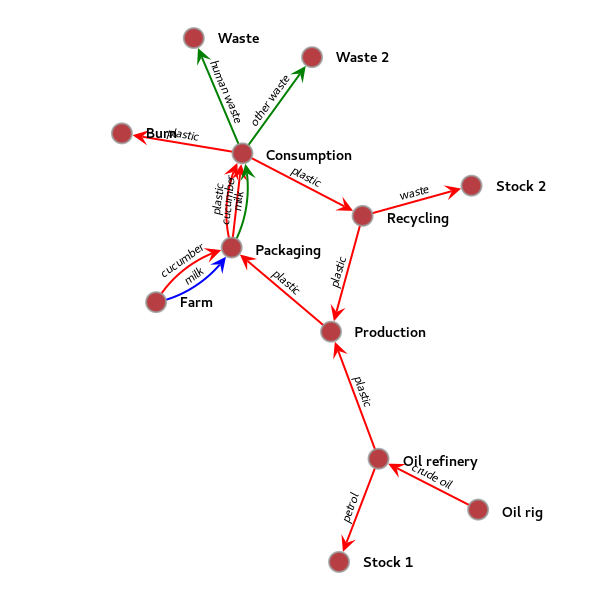

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa32a5653c8>

In [23]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_material, inline=True)

In [40]:
g_split.set_edge_filter(edge_mask)
g_split.set_vertex_filter(vtx_mask)

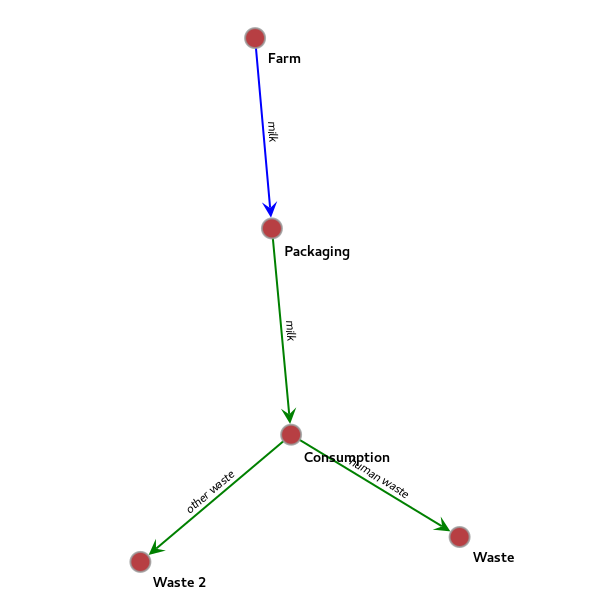

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa32a5e7a20>

In [25]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_material, inline=True)

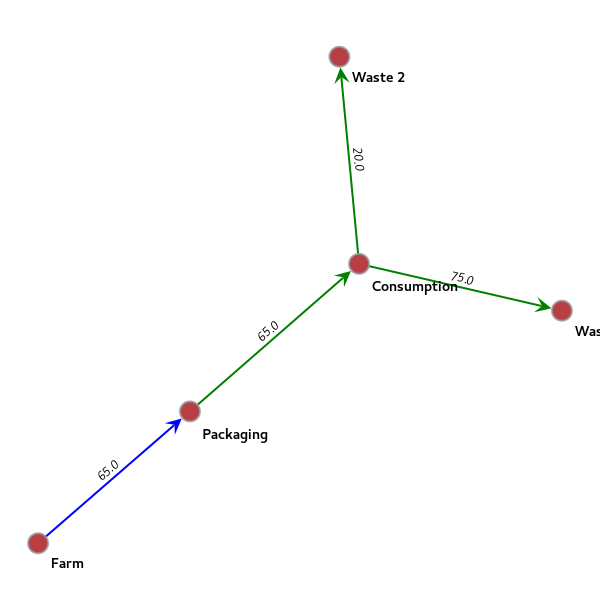

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa32a5cca90>

In [26]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_text, inline=True)

The flow between *Consumption* and *Waste* has a different material (human waste, other waste) than milk. Because this flow (human waste, other waste) doesn't have a composition, we need to calcuate the ratio of milk in it. Simply it is done as:

If *curent_mass* is larger than *previous_mass*:

    ratio = current_mass / previous_mass
    
But this step is best done in the preparation process. So practically, compute the material compositon for flows that do not have one, and are *aggregated* from previous flows. For example *cucumber + milk --> poop* , or *grapes + bottles + cork + paper --> bottled wine*

#### New method:

for each edge:

    new_mass = balancing_factor * edge_mass * (sum_in_sol_edges / sum_in_edges)

In [47]:
g_split.clear_filters()
eprop_mass_sol = eprop_mass.copy()
balancing_factor = 0.6
eprop_mass_sol[sol_e] = eprop_mass_sol[sol_e] * balancing_factor

for i,e in enumerate(g_split.edges()):
    if edge_mask[e]:
        src = e.source()
        all_in = g_split.get_in_edges(src)
        if len(all_in) > 0:
            print(e)
            sum_in = sum([eprop_mass[ein] for ein in all_in])
            flow = sum([eprop_mass[ein] for ein in all_in if edge_mask[ein]])
            eprop_mass_sol[e] = (flow / sum_in) * eprop_mass[e] * balancing_factor
#eprop_mass_sol2 = g_split.new_edge_property("double", vals=update_mass)
eprop_mass_sol_text = g_split.new_edge_property("string", vals=[round(i,2) for i in eprop_mass_sol]) 

(1, 6)
(6, 7)
(6, 11)


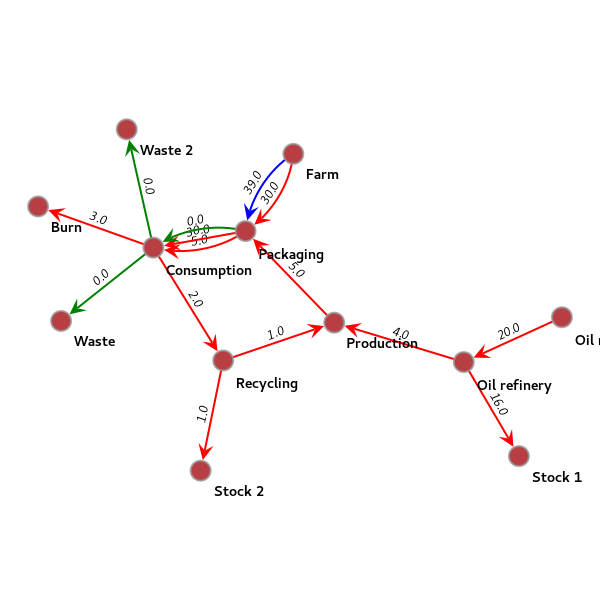

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa32a5e75f8, at 0x7fa328413dd8>

In [48]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":ecolors},
                   edge_text=eprop_mass_sol_text, inline=True)

In [46]:
for i, e in enumerate(g_split.edges()):
    print(e.source())
    print(eprop_material[e])

AttributeError: 'Edge' object has no attribute 'a'